# Zillow Analysis

## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

## Business Problem

A real estate investment firm is interested in knowing the top three best New Jersey counties to invest in based on return on investment (ROI).  

## Load Data for Analysis

In [2]:
df = pd.read_csv('data/zillow_data.csv')

In [3]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
df.shape

(14723, 272)

## Data Preprocessing

In [5]:
#Convert date columns to datetime objects
def get_datetimes(df):
    non_dt_cols = []
    dt_cols = []
    
    for c in df.columns:
        if c[0].isnumeric():
            dt_cols.append(c)
        else:
            non_dt_cols.append(c)
    #print(non_dt_cols)
    #print(dt_cols)
    dt_cols = list(pd.to_datetime(dt_cols, format = '%Y-%m'))
    
    df.columns = non_dt_cols + dt_cols
    return df

In [6]:
df = get_datetimes(df)
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## EDA and Visualization

In [7]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Reshape from Wide to Long Format

In [8]:
#Function to melt dataframe with datetime columns
def melt_data(df):
    melted = pd.melt(
        df,
        id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
        var_name='time')
    melted = melted.dropna(subset=['value'])
    return melted

In [9]:
#Updated dataframe
melted_df = melt_data(df)
melted_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,time,value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [10]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionID    int64         
 1   RegionName  int64         
 2   City        object        
 3   State       object        
 4   Metro       object        
 5   CountyName  object        
 6   SizeRank    int64         
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


## Seperate New Jersey Data

In [11]:
#Select NJ data for analysis
nj_df = melted_df[melted_df['State'] == 'NJ']
nj_df.set_index('time', inplace=True)

In [12]:
nj_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0
1996-04-01,61148,8701,Lakewood,NJ,New York,Ocean,74,153800.0
1996-04-01,61169,8753,Toms River,NJ,New York,Ocean,159,123400.0
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0


In [13]:
nj_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 133030 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    133030 non-null  int64  
 1   RegionName  133030 non-null  int64  
 2   City        133030 non-null  object 
 3   State       133030 non-null  object 
 4   Metro       133030 non-null  object 
 5   CountyName  133030 non-null  object 
 6   SizeRank    133030 non-null  int64  
 7   value       133030 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 9.1+ MB


In [14]:
#Change columns from int64 to string
nj_df['RegionID'] = nj_df['RegionID'].astype(str)
nj_df['RegionName'] = nj_df['RegionName'].astype(str)
nj_df['SizeRank'] = nj_df['SizeRank'].astype(str)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


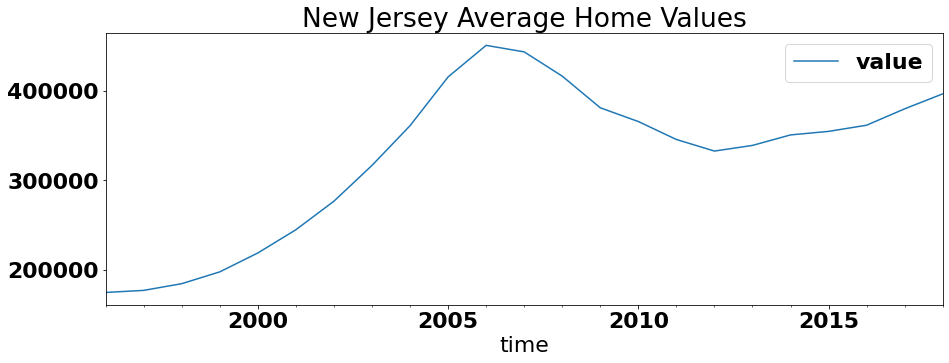

In [15]:
#Plot NJ average home values
nj_df.resample(rule='A').mean().plot(figsize=(15,5))
plt.title('New Jersey Average Home Values');

In [16]:
def adfuller_of(series):
    """Prints the Augmented Dickey-Fuller test results."""
    
    adf, pvalue, usedlag, nobs, crit_vals, resstore = adfuller(series)
    print(f'''
                          ADF: {adf}
                      P-Value: {pvalue}
                     Used Lag: {usedlag}
       Number of Observations: {nobs}
    Critical Values (for ADF): {crit_vals}
                  ResultStore: {resstore}
    ''')

In [17]:
#Perfrom Dickey-Fuller test to check for stationarity
#adfuller_of(nj_df['value'])

In [18]:
ROLL = 12

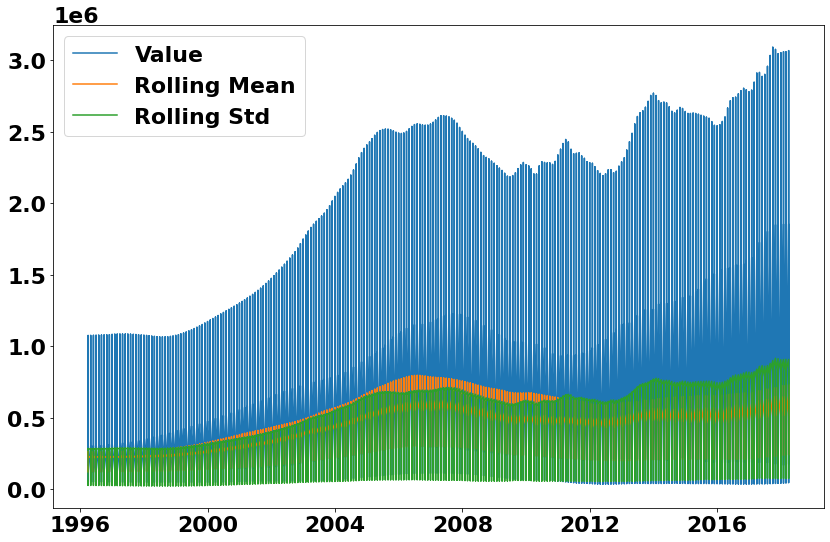

In [19]:
# Creating rolling mean and std.
nj_df['rolling_mean'] = nj_df['value'].rolling(window=ROLL).mean()
nj_df['rolling_std'] = nj_df['value'].rolling(window=ROLL).std()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(nj_df['value'], color='tab:blue', label='Value')
ax.plot(nj_df['rolling_mean'], color='tab:orange', label='Rolling Mean')
ax.plot(nj_df['rolling_std'], color='tab:green', label='Rolling Std')
ax.legend()
fig.tight_layout()

In [20]:
df_2 = pd.DataFrame(nj_df['value'])
df_2.head()

,value
time,
1996-04-01,301600.0
1996-04-01,153800.0
1996-04-01,123400.0
1996-04-01,145000.0
1996-04-01,137200.0


In [21]:
#decomposition = seasonal_decompose(df_2)

In [22]:
def yearly_resample(df):
#returns an annually resampled dataframe by mean values 
    resampled_df = df.resample(rule='A').mean()
    return resampled_df.head()

In [23]:
nj_yearly = yearly_resample(nj_df)

In [24]:
nj_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,174862.239929,174892.158494,74934.079925
1997-12-31,177175.514608,177172.771414,76498.221217
1998-12-31,184681.308101,184673.113103,81131.432595
1999-12-31,197897.675963,197881.407703,90302.357218
2000-12-31,219015.454847,218995.179006,105237.013636


In [25]:
#Resample NJ data into yearly average
#nj_df.resample(rule='A').mean()

In [61]:
#Calculate NJ Return on Investment (ROI) from 1996-2018
 
def ROI(cost, value):
    ROI = (value-cost)/cost
    return ROI   

In [62]:
ROI(174862, 393831)

1.2522389083963354

 - Overall New Jersey ROI from 1996 through 2018 was 125%.

## Seperate Data into Individual Counties

In [28]:
#Check unique county names
melted_df[melted_df['State'] == 'NJ']['CountyName'].unique()

array(['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
       'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer',
       'Morris', 'Atlantic', 'Gloucester', 'Cumberland', 'Warren',
       'Hunterdon', 'Cape May', 'Sussex', 'Salem'], dtype=object)

### Hudson County Analysis

In [36]:
def county_df(county):
    county_df = nj_df[(nj_df['CountyName'] == county)]
    return county_df

In [37]:
hudson_df = county_df('Hudson')

In [38]:
hudson_df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value,rolling_mean,rolling_std
time,,,,,,,,,,
1996-04-01,60545,7030,Hoboken,NJ,New York,Hudson,58,301600.0,NaN,NaN
1996-04-01,60518,7002,Bayonne,NJ,New York,Hudson,188,145000.0,NaN,NaN
1996-04-01,60639,7302,Jersey City,NJ,New York,Hudson,192,137200.0,NaN,NaN
1996-04-01,60599,7093,West New York,NJ,New York,Hudson,215,131700.0,NaN,NaN
1996-04-01,60594,7087,Union City,NJ,New York,Hudson,320,127300.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-04-01,60644,7307,Jersey City,NJ,New York,Hudson,1738,546600.0,355700.000000,126123.662260
2018-04-01,60547,7032,Kearny,NJ,New York,Hudson,2990,343200.0,298675.000000,108992.569597
2018-04-01,60600,7094,Secaucus,NJ,New York,Hudson,5837,520400.0,317225.000000,120505.036673


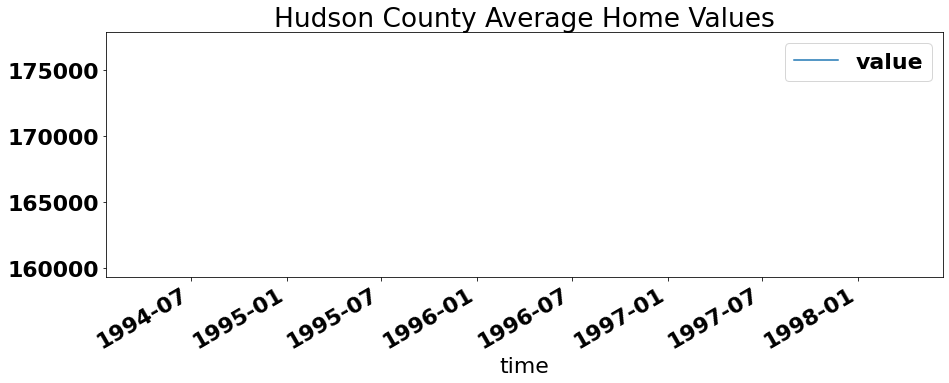

In [32]:
hudson_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Hudson County Average Home Values');

In [41]:
#Resample Hudson County data into yearly average
hudson_yearly = hudson_df.resample(rule='A').mean()
hudson_yearly.head()

,value,rolling_mean,rolling_std
time,,,
1996-12-31,152799.145299,163214.545455,75561.620496
1997-12-31,158035.256410,166099.412393,79151.091981
1998-12-31,168750.000000,174404.273504,84918.041214
1999-12-31,184584.615385,188239.209402,96738.507282
2000-12-31,207874.358974,209923.985043,114257.422042


In [42]:
hudson_yearly.iloc[0,0]

152799.1452991453

In [43]:
hudson_yearly.iloc[-1,0]

633382.6923076923

In [63]:
hudson_roi = ROI(152799, 633382)
type(hudson_roi)

float

In [64]:
roi_lst = []
roi_lst.append(hudson_roi)

In [65]:
roi_lst

[3.145197285322548]

 - Hudson County ROI from 1996 through 2018 was 315%.

### Ocean County Analysis

In [ ]:
ocean_df = nj_df[(nj_df['CountyName'] == 'Ocean')]
ocean_df.head()

In [ ]:
ocean_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Ocean County Average Home Values');

In [ ]:
#Resample Ocean County data into yearly average
ocean_yearly = ocean_df.resample(rule='A').mean()
ocean_yearly.head()

In [ ]:
ROI(140977, 358358)

### Middlesex County Analysis

In [ ]:
middlesex_df = nj_df[(nj_df['CountyName'] == 'Middlesex')]
middlesex_df.head()

In [ ]:
middlesex_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Middlesex County Average Home Values');

In [ ]:
#Resample Middlesex County data into yearly average
middlesex_yearly = middlesex_df.resample(rule='A').mean()
middlesex_yearly.head()

In [ ]:
ROI(153361, 333029)

### Somerset County Analysis

In [ ]:
somerset_df = nj_df[(nj_df['CountyName'] == 'Somerset')]
somerset_df.head()

In [ ]:
somerset_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Somerset County Average Home Values');

In [ ]:
#Resample Somerset County data into yearly average
somerset_yearly = somerset_df.resample(rule='A').mean()
somerset_yearly.head()

In [ ]:
ROI(262228, 516805)

### Monmouth County Analysis

In [ ]:
monmouth_df = nj_df[(nj_df['CountyName'] == 'Monmouth')]
monmouth_df.head()

In [ ]:
monmouth_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Monmouth County Average Home Values');

In [ ]:
#Resample Monmouth County data into yearly average
monmouth_yearly = monmouth_df.resample(rule='A').mean()
monmouth_yearly.head()

In [ ]:
ROI(197961, 547321)

### Passaic County Analysis

In [ ]:
#Create Passaic County dataframe
passaic_df = nj_df[(nj_df['CountyName'] == 'Passaic')]
passaic_df.head()

In [ ]:
#Take the mean of each Passaic County value
passaic_average = passaic_df.groupby('time').aggregate({'value':'mean'})
passaic_average

In [ ]:
passaic_yearly = passaic_df.resample(rule='A').mean()
passaic_yearly.head()

In [ ]:
ROI(148886, 294859)

In [ ]:
passaic_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Passaic County Average Home Values');

In [ ]:
#Check unique cities for Passaic County
passaic_df.City.unique()

In [ ]:
passaic_df.loc[passaic_df['City'] == 'North Haledon']['value'].plot()

In [ ]:
passaic_df.loc[passaic_df['City'] == 'Clifton']['value'].plot() 

### Essex County Analysis

In [ ]:
essex_df = nj_df[(nj_df['CountyName'] == 'Essex')]
essex_df.head()

In [ ]:
essex_yearly = essex_df.resample(rule='A').mean()
essex_yearly.head()

In [ ]:
ROI(196323, 515671)

### Camden County Analysis

In [ ]:
camden_df = nj_df[(nj_df['CountyName'] == 'Camden')]
camden_df.head()

In [ ]:
camden_yearly = camden_df.resample(rule='A').mean()
camden_yearly.head()

In [ ]:
ROI(105614, 192142)

### Bergen County Analysis

In [ ]:
bergen_df = nj_df[(nj_df['CountyName'] == 'Bergen')]
bergen_df.head()

In [ ]:
bergen_df.groupby('time').aggregate({'value':'mean'}).plot(figsize=(15,5))
plt.title('Bergen County Average Home Values');

In [ ]:
bergen_df.groupby('time').aggregate({'value':'mean'})

In [ ]:
bergen_yearly = bergen_df.resample(rule='A').mean()
bergen_yearly.head()

In [ ]:
ROI(242617, 563004)

In [ ]:
bergen_cities = bergen_df.groupby(['time', 'City']).aggregate({'value':'mean'})
bergen_cities.head()

In [ ]:
bergen_df.groupby(['time', 'City'])['value'].mean()

In [ ]:
#bergen_cities.resample(rule='A').mean()

### Burlington County Analysis

In [ ]:
burlington_df = nj_df[(nj_df['CountyName'] == 'Burlington')]
burlington_df.head()

In [ ]:
burlington_yearly = burlington_df.resample(rule='A').mean()
burlington_yearly.head()

In [ ]:
ROI(133883, 244695)

### Union County Analysis

In [ ]:
union_df = nj_df[(nj_df['CountyName'] == 'Union')]
union_df.head()

In [ ]:
union_yearly = union_df.resample(rule='A').mean()
union_yearly.head()

In [ ]:
ROI(169183, 393559)

### Mercer County Analysis

In [ ]:
mercer_df = nj_df[(nj_df['CountyName'] == 'Mercer')]
mercer_df.head()

In [ ]:
mercer_yearly = mercer_df.resample(rule='A').mean()
mercer_yearly.head()

In [ ]:
ROI(157606, 326565)

### Morris County Analysis

In [ ]:
morris_df = nj_df[(nj_df['CountyName'] == 'Morris')]
morris_df.head()

In [ ]:
morris_yearly = morris_df.resample(rule='A').mean()
morris_yearly.head()

In [ ]:
ROI(214271, 442678)

### Atlantic County Analysis

In [ ]:
atlantic_df = nj_df[(nj_df['CountyName'] == 'Atlantic')]
atlantic_df.head()

In [ ]:
atlantic_yearly = atlantic_df.resample(rule='A').mean()
atlantic_yearly.head()

In [ ]:
ROI(120473, 236446)

### Gloucester County Analysis

In [ ]:
gloucester_df = nj_df[(nj_df['CountyName'] == 'Gloucester')]
gloucester_df.head()

In [ ]:
gloucester_yearly = gloucester_df.resample(rule='A').mean()
gloucester_yearly.head()

In [ ]:
ROI(114002, 201674)

### Cumberland County Analysis

In [ ]:
cumberland_df = nj_df[(nj_df['CountyName'] == 'Cumberland')]
cumberland_df.head()

In [ ]:
cumberland_yearly = cumberland_df.resample(rule='A').mean()
cumberland_yearly.head()

In [ ]:
ROI(84953, 142456)

### Warren County Analysis

In [ ]:
warren_df = nj_df[(nj_df['CountyName'] == 'Warren')]
warren_df.head()

In [ ]:
warren_yearly = warren_df.resample(rule='A').mean()
warren_yearly.head()

In [ ]:
ROI(150987, 247808)

### Hunterdon County Analysis

In [ ]:
hunterdon_df = nj_df[(nj_df['CountyName'] == 'Hunterdon')]
hunterdon_df.head()

In [ ]:
hunterdon_yearly = hunterdon_df.resample(rule='A').mean()
hunterdon_yearly.head()

In [ ]:
ROI(208477, 368418)

### Cape May County Analysis

In [ ]:
cape_may_df = nj_df[(nj_df['CountyName'] == 'Cape May')]
cape_may_df.head()

In [ ]:
cape_may_yearly = cape_may_df.resample(rule='A').mean()
cape_may_yearly.head()

In [ ]:
ROI(164170, 592579)

### Sussex County Analysis

In [ ]:
sussex_df = nj_df[(nj_df['CountyName'] == 'Sussex')]
sussex_df.head()

In [ ]:
sussex_yearly = sussex_df.resample(rule='A').mean()
sussex_yearly.head()

In [ ]:
ROI(139554, 229287)

### Salem County Analysis

In [ ]:
salem_df = nj_df[(nj_df['CountyName'] == 'Salem')]
salem_df.head()

In [ ]:
salem_yearly = salem_df.resample(rule='A').mean()
salem_yearly

In [ ]:
salem_yearly.iloc[0,0]

In [ ]:
salem_yearly.iloc[-1,0]

In [ ]:
ROI(84093, 147042)

## Top ROI Counties

In [ ]:
data = {'Average Return on Investment %':[315, 154, 117, 97, 176, 98, 163, 82, 132, 83, 133, 107, 107, 96, 77, 68,
                                       64, 77, 261, 64, 75]}
roi_comparison = pd.DataFrame(data, index=['Hudson', 'Ocean', 'Middlesex', 'Somerset', 'Monmouth', 'Passaic',
                                          'Essex', 'Camden', 'Bergen', 'Burlington', 'Union', 'Mercer', 'Morris',
                                          'Atlantic', 'Gloucester', 'Cumberland', 'Warren', 'Hunterdon',
                                          'Cape May', 'Sussex', 'Salem'])
roi_comparison.sort_values(by=['Average Return on Investment %'], ascending=False).head()

In [ ]:
hudson_yearly = hudson_df['value'].resample(rule='A').mean()
cape_may_yearly = cape_may_df['value'].resample(rule='A').mean()
monmouth_yearly = monmouth_df['value'].resample(rule='A').mean()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hudson_yearly, color='tab:blue', label='Hudson County')
ax.plot(cape_may_yearly, color='tab:orange', label='Cape May County')
ax.plot(monmouth_yearly, color='tab:green', label='Monmouth County')
ax.legend()
fig.tight_layout()

## ARIMA Modeling

In [ ]:
hudson_monthly = hudson_df.resample(rule='M').mean()
hudson_monthly['value'].plot();

In [ ]:
result = seasonal_decompose(hudson_monthly['value'])
result.plot() #plt.gcf().autofmt_xdate()

In [ ]:
stepwise_fit = auto_arima(hudson_monthly['value'], trace=True)
stepwise_fit.summary()

In [ ]:
len(hudson_monthly)

In [ ]:
train = hudson_monthly.iloc[:205]
test = hudson_monthly.iloc[205:]

In [ ]:
train.isna().sum()

In [ ]:
model = ARIMA(train['value'], order=(2,2,2))
results = model.fit()
results.summary()

In [ ]:
hudson_mean = hudson_df.groupby('time').aggregate({'value':'mean'})
hudson_mean.head()

In [ ]:
# Creating rolling mean and std.
hudson_mean['rolling_mean'] = hudson_mean['value'].rolling(window=ROLL).mean()
hudson_mean['rolling_std'] = hudson_mean['value'].rolling(window=ROLL).std()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(hudson_mean['value'], color='tab:blue', label='Value')
ax.plot(hudson_mean['rolling_mean'], color='tab:orange', label='Rolling Mean')
ax.plot(hudson_mean['rolling_std'], color='tab:green', label='Rolling Std')
ax.legend()
fig.tight_layout()

In [ ]:
#decomposition = seasonal_decompose(hudson_mean['value'])
#decomposition.plot()

In [ ]:
hudson_value = hudson_mean[['value']]

In [ ]:
hudson_shift_12 = hudson_value.shift(periods=12)

lag_12 = pd.concat([hudson_shift_12, hudson_value], axis=1)

lag_12.corr()

In [ ]:
lag_12.plot(figsize=(18,6));

In [ ]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(hudson_value);

In [ ]:
#Plot the autocorrelation function
plot_acf(hudson_value);

In [ ]:
plot_pacf(hudson_value);

## SARIMA Modeling

In [ ]:
auto_arima(hudson_monthly['value'], seasonal=True, m=12).summary()

In [ ]:
len(hudson_monthly)

In [ ]:
train_2 = hudson_monthly.iloc[:229]
test_2 = hudson_monthly.iloc[229:]

In [ ]:
model_2 = SARIMAX(hudson_monthly['value'], order = (1,1,3))

In [ ]:
results = model_2.fit()
results.summary()

In [ ]:
start = len(train_2)
end = len(train_2) + len(test) - 1

In [ ]:
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')
predictions

In [ ]:
test['value'].plot(legend=True,figsize=(12,8))
predictions.plot(legend=True);

In [ ]:
future_model = SARIMAX(hudson_monthly['value'], order = (1,1,3))
results_future = future_model.fit()

In [ ]:
fcast = results_future.predict(len(hudson_monthly), len(hudson_monthly)+11, typ='levels').rename('SARIMA Forecast')
fcast

In [ ]:
hudson_monthly['value'].plot(legend=True, figsize=(12,8))
fcast.plot(legend=True);

In [ ]:
def get_top_counties(df, n_top_counties=3):
    
    #get unique counties from dataframe as list
    unique_counties = []
    for c in nj_df.CountyName.unique():
        unique_counties.append(c)
    print(unique_counties)
    
    #set up empty dictionary to store model, aic, county 
    county_dict = {County: {model:'', aic:''}}
    
    #iterate over counties (for county in counties list)
    for county in unique_counties:
    
    #slice out county from dataframe, only see rows where county = county
    nj_df[(nj_df['CountyName'] == county)]
    
    #split data
    train = df.iloc[:229]
    test = df.iloc[229:]
    
    #iterate over model orders to try to find the best model
    for model in county_dict:
        return county_dict[County][aic]

In [ ]:
unique_counties = []
for c in nj_df.CountyName.unique():
    unique_counties.append(c)
print(unique_counties)

In [ ]:
highest_number = 0
numbers_lst = [0,1,2,5,1,10,9,8,7,10,5]
for num in numbers_lst:
    if num > highest_number:
        highest_number = num
print(highest_number)